In [89]:
import glob
import matplotlib.pyplot as plt
from lightkurve import KeplerTargetPixelFile
from pyke import kepio, kepmsg, kepplot
from copy import copy
from lightkurve import KeplerTargetPixelFile
import glob
from copy import copy
from pyke import kepio, kepmsg, kepplot
import matplotlib.pyplot as plt
import lightkurve
import numpy as np
import warnings
from astropy.visualization import (PercentileInterval, ImageNormalize,
                                   SqrtStretch, LinearStretch)
from matplotlib.colors import LogNorm
import sys
from matplotlib import patches

In [90]:
tpffilelist=glob.glob('attilafiles/ktwo*lpd-targ.fits')
mfilelist=[each[:-5]+'.kepmask' for each in infilelist]

In [113]:
def plot_image(image, ax=None, scale='linear', origin='lower',
               xlabel='Pixel Column Number', ylabel='Pixel Row Number',
               clabel='Flux ($e^{-}s^{-1}$)', title=None, show_colorbar=True,
               **kwargs):
    """Utility function to plot a 2D image
    Parameters
    ----------
    image : 2d array
        Image data.
    ax : matplotlib.axes._subplots.AxesSubplot
        A matplotlib axes object to plot into. If no axes is provided,
        a new one will be generated.
    scale : str
        Scale used to stretch the colormap.
        Options: 'linear', 'sqrt', or 'log'.
    origin : str
        The origin of the coordinate system.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.
    clabel : str
        Label for the color bar.
    title : str or None
        Title for the plot.
    show_colorbar : bool
        Whether or not to show the colorbar
    kwargs : dict
        Keyword arguments to be passed to `matplotlib.pyplot.imshow`.
    Returns
    -------
    ax : matplotlib.axes._subplots.AxesSubplot
        The matplotlib axes object.
    """
    if ax is None:
        _, ax = plt.subplots()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)  # ignore image NaN values
        mask = np.nan_to_num(image) > 0
        if mask.any() > 0:
            vmin, vmax = PercentileInterval(95.).get_limits(image[mask])
        else:
            vmin, vmax = 0, 0

    norm = None
    if scale is not None:
        if scale == 'linear':
            norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch(), clip=False)
        elif scale == 'sqrt':
            norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch(), clip=False)
        elif scale == 'log':
            # To use log scale we need to guarantee that vmin > 0, so that
            # we avoid division by zero and/or negative values.
            norm = LogNorm(vmin=max(vmin, sys.float_info.epsilon), vmax=vmax,
                           clip=True)
        else:
            raise ValueError("scale {} is not available.".format(scale))
    cax = ax.imshow(image, origin=origin, norm=norm, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if show_colorbar:
        cbar = plt.colorbar(cax, ax=ax, norm=norm, label=clabel)
        cbar.ax.yaxis.set_tick_params(tick1On=False, tick2On=False)
        cbar.ax.minorticks_off()
        
    for i in range(tpf.shape[1]):
        for j in range(tpf.shape[2]):
            if aperture_mask[i, j]:
                ax.add_patch(patches.Rectangle((j+tpf.column, i+tpf.row),
                    1, 1, color=mask_color, fill=True,
                    alpha=.6))    
    
    return ax

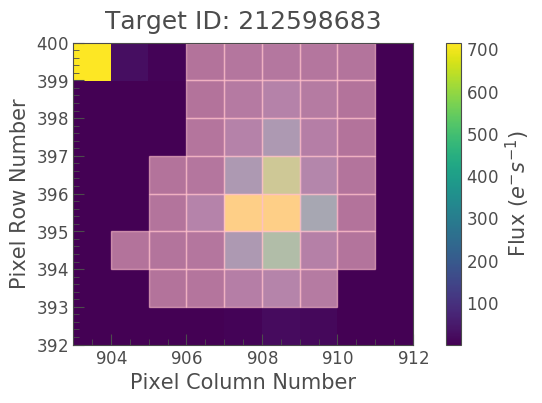

In [92]:
for i, eachtpf in enumerate(tpffilelist):
    if i<1:
        
        tpffile=eachtpf
        maskfile=mfilelist[i]
        
        logfile='thisislogfile'

        kepid, channel, skygroup, module, output, quarter, season, \
        ra, dec, column, row, kepmag, xdim, ydim, pixels = \
        kepio.readTPF(tpffile, 'FLUX', logfile, verbose=True)
        
        ymin = copy(row)
        ymax = ymin + ydim
        xmin = copy(column)
        xmax = xmin + xdim

        lines = kepio.openascii(maskfile, 'r', None, False)
        for line in lines:
            mask = []
            work = line.strip().split('|')
            y0 = int(work[3])
            x0 = int(work[4])
            work = work[5].split(';')
            for i in range(len(work)):
                n = int(work[i].split(',')[0]) + y0
                m = int(work[i].split(',')[1]) + x0
                mask.append(str(m) + ',' + str(n))

        xcords=[int(each.split(',')[0]) for each in mask]
        ycords=[int(each.split(',')[1]) for each in mask]

        newy=[each-ymin for each in ycords]
        newx=[each-xmin for each in xcords]

        tpf=lightkurve.targetpixelfile.KeplerTargetPixelFile(tpffile)

        inrangeindices=[]
        for ithcord, xcord in enumerate(xcords):
            if xcord>xmin and xcord<xmax:
                if ycords[ithcord]>ymin and ycords[ithcord]<ymax:
                    inrangeindices.append(ithcord)

        newxcords=np.asarray(xcords)[inrangeindices]
        newycords=np.asarray(ycords)[inrangeindices]

        newxcords=[each-xmin for each in newxcords]
        newycords=[each-ymin for each in newycords]            
                    
        grid=np.zeros(tpf.flux[0].shape,dtype=int)
        
        for index, each in enumerate(newxcords):
            grid[newycords[index]][each]=1
        
        #print(grid)
        
        tpf.plot(aperture_mask=grid)
        plt.show()

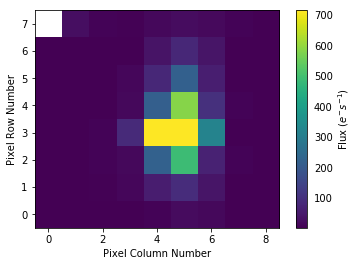

In [114]:
aperture_mask=grid
mask_color='pink'
ax = plot_image(tpf.flux[0],scale='linear')


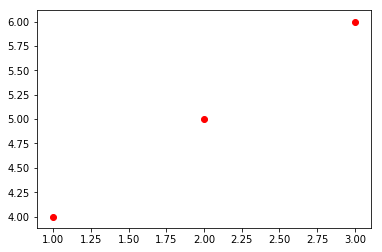

In [108]:
plt.scatter([1,2,3],[4,5,6],c='r')